#### Authorship

Created by Shawn Tan (banchan@gmail.com) for DJ BambahMukku Lab

#### Changelog

2/24/25 - Added imports and loading of face_rhythm data, as well as raw displacement over time.
3/25/25 - Added bonsai stimuli alignment
3/26/25 - Added individual plots for stimuli
3/27/25 

#### Description
- Processes bonsai output for stimuli alignment.
- Analyzes face_rhythm data

#### Instructions
- Install face_rhythm (this script calls on some functions from there)
- Install seaborn (plotting library)
- `conda activate face_rhythm`
- `jupyter notebook`

#### Project organization
- face_rhythm folder (clone modified repository https://github.com/banchan86/face-rhythm-DJ)
- airpuff data folder
  - experimental day folder
    - subject ID folder
      - bonsai output
      - facerhythm output

# Setup

Import Python libraries

In [121]:
import seaborn as sns
import face_rhythm as fr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path

Define constants for folder location

In [224]:
data_folder = "Airpuff_Data"
experiment_day = "03192025_Cage_PN36"
subjectID = "LLIM"
session_folder = Path("../../").resolve() / data_folder / experiment_day / subjectID
rejection_file = session_folder / "bonsai_aligned" / "frame_rejection.csv"

# Individual Session Analysis

If data has already been processed, skip to loading data (just before the plotting section).

### Process face_rhythm_data

Load face_rhythm_data

In [225]:
raw_data = fr.h5_handling.simple_load(session_folder / "analysis_files" / "PointTracker.h5")

Calculate frame-wise displacement

In [226]:
# Compute displacement: difference between consecutive frames
delta = np.diff(raw_data["points_tracked"]["0"], axis = 0) # Shape: (33484, 185, 2)

# Compute Euclidean distance for each point
displacement = np.linalg.norm(delta, axis=2)  # Shape: (33484, 185)

# Compute mean displacement across all points
mean_displacement = np.mean(displacement, axis=1)  # Shape: (33484,)

# Pad mean displacement with one frame at start as it will be n-1
mean_displacement = np.insert(mean_displacement, 0, 0)

### Process bonsai data

In [227]:
# Import timestamp csv as a pandas dataframe
video_timestamp_csv = next(file for file in session_folder.glob("*.csv") if "video" in file.name)
video_timestamp_df = pd.read_csv(video_timestamp_csv, parse_dates = [1])
video_timestamp_df.head()

,Frame,Timestamp
0,0,2025-03-19 14:28:28.862848-07:00
1,1,2025-03-19 14:28:28.872499200-07:00
2,2,2025-03-19 14:28:28.882867200-07:00
3,3,2025-03-19 14:28:28.892608-07:00
4,4,2025-03-19 14:28:28.902489600-07:00


If video was trimmed at start adjust video_timestamp_df to drop the frames at start. This is not for frame rejection in the middle of the video, there is a separate section for that.

In [228]:
if len(mean_displacement) != len(video_timestamp_df):
    diff = len(video_timestamp_df) - len(mean_displacement)
    
    if diff > 0:
        print(f"Video trimming detected, trimming first {diff} frame(s) from video_timestamp_df")
        
        # Trim rows
        video_timestamp_df = video_timestamp_df.iloc[diff:].reset_index(drop=True)
        
        # Reset frame numbers to start from 0
        video_timestamp_df["Frame"] = np.arange(len(video_timestamp_df))
        
    else:
        pass

In [229]:
# Import TTL readout csv as a pandas dataframe
TTL_readout_csv = next(file for file in session_folder.glob("*.csv") if "TTL_received" in file.name)
TTL_readout_df = pd.read_csv(TTL_readout_csv, header = None, names = ["TTL", "Timestamp"], parse_dates = [1])
TTL_readout_df = TTL_readout_df.drop(index=0)
TTL_readout_df = TTL_readout_df.reset_index(drop=True)
TTL_readout_df.head()

,TTL,Timestamp
0,True,2025-03-19 14:29:02.495616-07:00
1,False,2025-03-19 14:29:02.544947200-07:00
2,True,2025-03-19 14:29:32.509222400-07:00
3,False,2025-03-19 14:29:32.558374400-07:00
4,True,2025-03-19 14:29:57.525427200-07:00


In [230]:
# Zero Timestamps to experiment start time
experiment_start = video_timestamp_df.iloc[0, 1]

video_timestamp_df["Time_since_start"] = video_timestamp_df.iloc[:, 1] - experiment_start
video_timestamp_df["Experiment_time_seconds"] = video_timestamp_df["Time_since_start"].dt.total_seconds()
video_timestamp_df = video_timestamp_df.drop(columns=["Time_since_start"])

TTL_readout_df["Time_since_start"] = TTL_readout_df.iloc[:, 1] - experiment_start
TTL_readout_df["Experiment_time_seconds"] = TTL_readout_df["Time_since_start"].dt.total_seconds()
TTL_readout_df = TTL_readout_df.drop(columns=["Time_since_start"])

In [231]:
# Verify dataframe
video_timestamp_df.head()

,Frame,Timestamp,Experiment_time_seconds
0,0,2025-03-19 14:28:28.862848-07:00,0.000000
1,1,2025-03-19 14:28:28.872499200-07:00,0.009651
2,2,2025-03-19 14:28:28.882867200-07:00,0.020019
3,3,2025-03-19 14:28:28.892608-07:00,0.029760
4,4,2025-03-19 14:28:28.902489600-07:00,0.039642


In [232]:
# Verify dataframe
TTL_readout_df.head()

,TTL,Timestamp,Experiment_time_seconds
0,True,2025-03-19 14:29:02.495616-07:00,33.632768
1,False,2025-03-19 14:29:02.544947200-07:00,33.682099
2,True,2025-03-19 14:29:32.509222400-07:00,63.646374
3,False,2025-03-19 14:29:32.558374400-07:00,63.695526
4,True,2025-03-19 14:29:57.525427200-07:00,88.662579


In [233]:
# Find video frame frame that comes after TTL is received

# Extract TTL on times
TTL_on_times = TTL_readout_df[TTL_readout_df["TTL"] == True]["Experiment_time_seconds"].reset_index(drop=True)

# Extract video timestamps and frame numbers
frame_times = video_timestamp_df.iloc[:, 2]
frame_numbers = video_timestamp_df.iloc[:, 0]

# Use searchsorted to find matching frame indices
indices = frame_times.searchsorted(TTL_on_times)

# Get corresponding frame numbers
matched_frames = frame_numbers.iloc[indices].reset_index(drop=True)
matched_frame_times = frame_times.iloc[indices].reset_index(drop=True)

# Create a result DataFrame
airpuff_df = pd.DataFrame({
    "Matched_frame": matched_frames,
    "TTL_on_time": TTL_on_times,
    "Frame_time": matched_frame_times
})

In [235]:
# Define all airpuffs and the number of trials in a psi_trials.csv file saved in session folder
# Should match total number of trials

psi_file = session_folder / "psi_trials.csv"
psi_trials_df = pd.read_csv(psi_file)

psi_values = [
    row["PSI"]
    for _, row in psi_trials_df.iterrows()
    for _ in range(int(row["Number_of_trials"]))
]

if len(psi_values) != len(airpuff_df):
    raise ValueError("Mismatch between number of PSI values and airpuff_df rows.")
else:
    airpuff_df["PSI"] = psi_values


### Calculate baseline movement and peak displacement

Aniqa (2024) paper

- At the beginning of each session, an image of a ruler was used to ensure identical viewing distances across sessions. 
- Trials in which the animal exhibited movement during the 10-frame baseline collection period before the stimulus were discarded during analysis (framerate was 120 fps for them so about less than 100 ms?)
- Videos were analyzed for peak body displacement 500 ms following the air puff stimulus


Shawn's notes 3/27/25

- We don't have a ruler, but we can normalize to the short edge of the container.
- I think we can use 10 frames and make it 100ms before stimulus. We probably need a displacement threshold for "movement"

In [236]:
# Parameters
fps = 100
baseline_period = int(0.1 * fps)     # 100 ms in frames
post_stimuli_period = int(0.5 * fps) # 500 ms in frames

# Empty columns to populate
pre_displacements = []
post_peaks = []

for _, row in airpuff_df.iterrows():
    center = int(row["Matched_frame"])

    # Pre-stimulus (baseline) window
    pre_start = max(center - baseline_period, 0)
    pre_vals = mean_displacement[pre_start:center]
    pre_avg = np.mean(pre_vals)

    # Post-stimulus window
    post_end = min(center + post_stimuli_period, len(mean_displacement))
    post_vals = mean_displacement[center:post_end]
    post_peak = np.max(post_vals)

    # Store results
    pre_displacements.append(pre_avg)
    post_peaks.append(post_peak)

# Add to DataFrame
airpuff_df["Pre_displacement_avg"] = pre_displacements
airpuff_df["Post_displacement_peak"] = post_peaks

### Apply automatic rejection

Reject trials based on baseline movement

In [237]:
# Parameters
threshold = 1

airpuff_df["automatic_rejection"] = airpuff_df["Pre_displacement_avg"] > threshold

In [238]:
# inspect airpuff_df to see if values look right
airpuff_df

,Matched_frame,TTL_on_time,Frame_time,PSI,Pre_displacement_avg,Post_displacement_peak,automatic_rejection
0,3362,33.632768,33.633446,0.10,0.115815,11.906624,False
1,6363,63.646374,63.655949,0.10,3.744204,2.526393,True
2,8863,88.662579,88.666150,0.10,0.133780,0.421885,False
3,10964,109.680538,109.685043,0.25,0.148839,13.703472,False
4,13265,132.697843,132.704384,0.25,0.232511,5.496855,False
5,15865,158.709171,158.715302,0.25,0.067293,20.568611,False
6,18765,187.719181,187.727066,0.50,0.144515,20.959806,False
7,21765,217.736883,217.739610,0.50,0.210219,16.442738,False
8,23966,239.750387,239.758592,0.50,0.070914,16.570374,False
9,26865,268.756301,268.760486,0.75,0.247881,5.593740,False


Reject trial based on loss of mesh tracking

In [239]:
# Default: set all to False
airpuff_df["frame_rejection"] = False

if rejection_file.exists():
    print("Found frame_rejection.csv — checking for overlapping frames.")

    # Step 2: Load the file
    rejection_ranges = pd.read_csv(rejection_file)

    # Step 3: Check each Matched_frame against all rejection ranges
    def is_rejected(frame):
        return any((frame >= start) and (frame <= end)
                   for start, end in zip(rejection_ranges["Frame_start"], rejection_ranges["Frame_end"]))

    airpuff_df["frame_rejection"] = airpuff_df["Matched_frame"].apply(is_rejected)

else:
    print("No frame_rejection.csv found — assuming all frames are valid.")

No frame_rejection.csv found — assuming all frames are valid.


In [240]:
# inspect airpuff_df to see if values look right
airpuff_df

,Matched_frame,TTL_on_time,Frame_time,PSI,Pre_displacement_avg,Post_displacement_peak,automatic_rejection,frame_rejection
0,3362,33.632768,33.633446,0.10,0.115815,11.906624,False,False
1,6363,63.646374,63.655949,0.10,3.744204,2.526393,True,False
2,8863,88.662579,88.666150,0.10,0.133780,0.421885,False,False
3,10964,109.680538,109.685043,0.25,0.148839,13.703472,False,False
4,13265,132.697843,132.704384,0.25,0.232511,5.496855,False,False
5,15865,158.709171,158.715302,0.25,0.067293,20.568611,False,False
6,18765,187.719181,187.727066,0.50,0.144515,20.959806,False,False
7,21765,217.736883,217.739610,0.50,0.210219,16.442738,False,False
8,23966,239.750387,239.758592,0.50,0.070914,16.570374,False,False
9,26865,268.756301,268.760486,0.75,0.247881,5.593740,False,False


# Make filtered results dataframe

In [241]:
# Ensure frame_rejection column exists
if "frame_rejection" not in airpuff_df.columns:
    airpuff_df["frame_rejection"] = False

In [242]:
# Filter out trials with either rejection type
filtered_df = airpuff_df[
    (~airpuff_df["automatic_rejection"]) & (~airpuff_df["frame_rejection"])
].copy()

# Make PSI column categorical
filtered_df["PSI"] = filtered_df["PSI"].astype(str)

# Save Processed Data

In [243]:
# Define folder paths
output_folder = session_folder / "bonsai_aligned"
results_folder = session_folder / "results"

# Create the folder if it doesn't exist
output_folder.mkdir(exist_ok=True)
results_folder.mkdir(exist_ok=True)

# Save dataframes
video_timestamp_df.to_csv(output_folder / "video_aligned.csv", index = False)
TTL_readout_df.to_csv(output_folder / "TTL_aligned.csv", index = False)
airpuff_df.to_csv(results_folder / "all_airpuff_aligned.csv", index = False)
filtered_df.to_csv(results_folder / "filtered_results.csv", index=False)

# Save displacement
np.save(output_folder / "mean_displacement.npy", mean_displacement)


# Load Processed Data

In [244]:
mean_displacement = np.load(output_folder / "mean_displacement.npy")
airpuff_df = pd.read_csv(results_folder / "all_airpuff_aligned.csv")
video_timestamp_df = pd.read_csv(output_folder / "video_aligned.csv", parse_dates=["Timestamp"])
TTL_readout_df = pd.read_csv(output_folder / "TTL_aligned.csv", parse_dates=["Timestamp"])

filtered_df = pd.read_csv(results_folder / "filtered_results.csv", )
filtered_df["PSI"] = filtered_df["PSI"].astype(str)

if rejection_file.exists():
    rejection_ranges = pd.read_csv(rejection_file)

# Plot frame-wise displacement over time with airpuffs overlaid

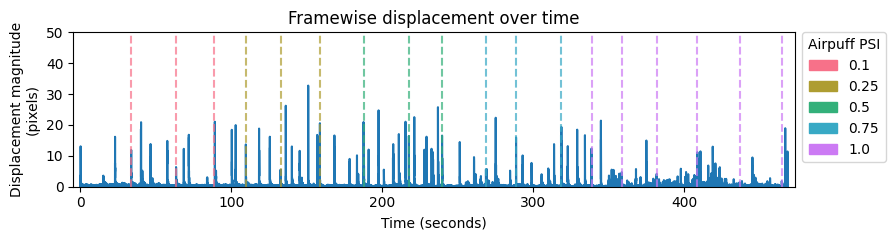

In [245]:
# Create time axis
time_axis = np.arange(len(mean_displacement)) / fps  # seconds

# Set up base figure
plt.figure(figsize=(10, 2.5))
sns.lineplot(x=time_axis, y=mean_displacement)

# Pick a color palette based on unique PSI levels
unique_psi = sorted(airpuff_df["PSI"].unique())
palette = sns.color_palette("husl", len(unique_psi))

# Map each PSI value to a color
psi_to_color = {psi: palette[i] for i, psi in enumerate(unique_psi)}

# Step 3: Overlay vertical lines for airpuffs, colored by PSI
for _, row in airpuff_df.iterrows():
    psi = row["PSI"]
    color = psi_to_color[psi]
    time_of_event = row["Frame_time"]
    plt.axvline(x=row["Frame_time"], color=color, linestyle="--", alpha=0.7)

# Create PSI legend
from matplotlib.patches import Patch

psi_patches = [Patch(facecolor=color, edgecolor=color, label=f"{psi}") for psi, color in psi_to_color.items()]
all_handles = psi_patches.copy()
all_labels = [f"{psi}" for psi in psi_to_color]


# Check and shade rejected frame regions if rejection file exists, also adds legend for tracking lost
if rejection_file.exists():
    
    for _, row in rejection_ranges.iterrows():
        start_time = row["Frame_start"] / fps
        end_time = row["Frame_end"] / fps
        plt.axvspan(start_time, end_time, color="grey", alpha=0.3, label="Tracking lost")

    # Add "Tracking lost" to legend once
    all_handles.append(Patch(facecolor="grey", alpha=0.3, label="Tracking lost"))
    all_labels.append("Tracking lost")
                      

# Titles, labels and axis limits
plt.legend(handles=all_handles, labels=all_labels, title="Airpuff PSI", bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0)
plt.title("Framewise displacement over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Displacement magnitude\n(pixels)")
plt.ylim(0, 50)

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.margins(x=0.01)


# Save image
plt.savefig(session_folder / "visualizations" / "raw_displacement_over_time.png", dpi=300)

Generates graphs for each airpuff

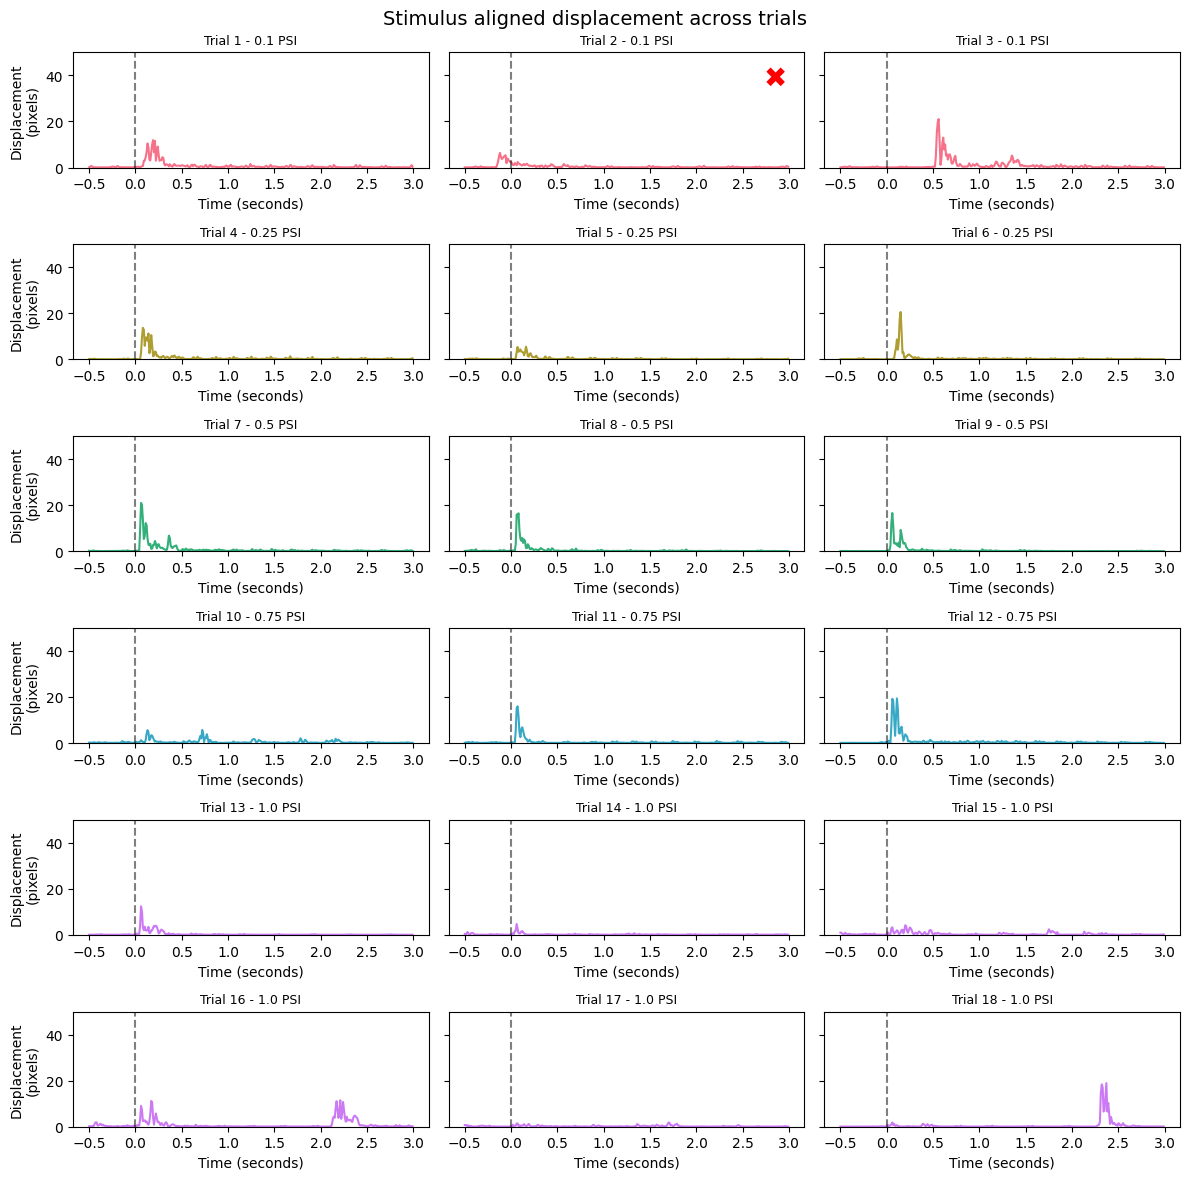

In [246]:
# Timeframe
pre_frames = 50
post_frames = 300

# Layout settings
n_trials = len(airpuff_df)
n_cols = 3  # number of plots per row
n_rows = math.ceil(n_trials / n_cols)

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2), sharey=True)
axes = axes.flatten()  # make it easy to index

for i, row in airpuff_df.iterrows():
    ax = axes[i]
    center = int(row["Matched_frame"])
    psi = row["PSI"]

    start = max(center - pre_frames, 0)
    end = min(center + post_frames, len(mean_displacement))

    segment = mean_displacement[start:end]
    x = np.arange(-pre_frames, len(segment) - pre_frames) / fps

    sns.lineplot(x=x, y=segment, ax=ax, color=psi_to_color[psi])
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f"Trial {i+1} - {psi} PSI", fontsize=9)
    ax.set_ylim(0, 50)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Displacement\n(pixels)")
    
    # ✖ mark for trials rejected due to baseline movement
    if row["automatic_rejection"] and not row.get("frame_rejection", False):
        ax.text(
            0.95, 0.9, "✖",
            transform=ax.transAxes,
            fontsize=20,
            color="red",
            ha="right",
            va="top"
        )
    
    # Big red ✖ for frame tracking loss
    if "frame_rejection" in airpuff_df.columns and row["frame_rejection"]:
        ax.text(
            0.5, 0.5, "✖",
            transform=ax.transAxes,
            fontsize=100,
            color="red",
            ha="center",
            va="center",
            alpha=0.2
        )
    
# Remove unused axes if n_trials doesn't fill the grid
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Stimulus aligned displacement across trials", fontsize=14)
plt.tight_layout()

# Save image
plt.savefig(session_folder / "visualizations" / "individual_airpuff.png", dpi=300)

Plot summary data

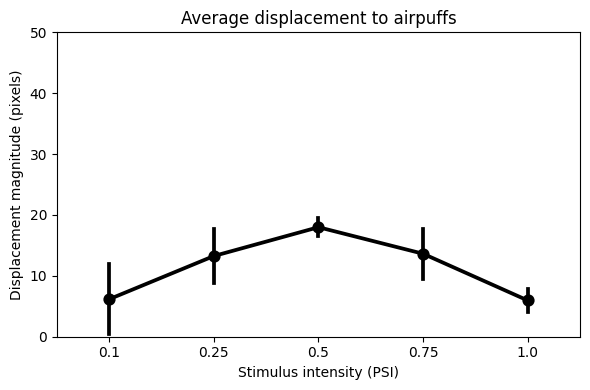

In [247]:
plt.figure(figsize=(6, 4))
sns.pointplot(
    data=filtered_df,
    x="PSI",
    y="Post_displacement_peak",
    errorbar="se",
    color="black",
    markers="o",
    linestyles="-"
)

plt.title("Average displacement to airpuffs")
plt.xlabel("Stimulus intensity (PSI)")
plt.ylabel("Displacement magnitude (pixels)")
plt.ylim(0, 50)
plt.tight_layout()

# Save plot
plt.savefig(session_folder / "visualizations" / "average_airpuffs.png", dpi=300)

# Supplementary:TTL characterisation

In [23]:
# Shawn's notes 3/26/25
# I wrote this section to characterize both the duration and latency for the TTL.
# Dont need to run this section again unless you suspect something is obviously wrong
TTL_sent_csv = next(file for file in Path(session_folder).glob("*.csv") if "TTL_sent" in file.name)
TTL_sent_df = pd.read_csv(TTL_sent_csv, header = None, names = ["TTL", "Timestamp"], parse_dates = [1])
TTL_sent_df.head()


,TTL,Timestamp
0,True,2025-03-18 15:32:05.887667200-07:00
1,False,2025-03-18 15:32:05.950924800-07:00
2,True,2025-03-18 15:32:34.904243200-07:00
3,False,2025-03-18 15:32:34.966822400-07:00
4,True,2025-03-18 15:33:00.914316800-07:00


In [24]:
print(TTL_readout_df.dtypes)
print(TTL_sent_df.dtypes)

TTL                               bool
Timestamp    datetime64[ns, UTC-07:00]
dtype: object
TTL                               bool
Timestamp    datetime64[ns, UTC-07:00]
dtype: object


In [32]:
# Calculate TTL duration and check for any outlier values
TTL_on_times = TTL_readout_df[TTL_readout_df["TTL"] == True]["Timestamp"].reset_index(drop=True)
TTL_off_times = TTL_readout_df[TTL_readout_df["TTL"] == False]["Timestamp"].reset_index(drop=True)
durations = TTL_off_times - TTL_on_times
durations_in_milliseconds = durations.dt.total_seconds()*1000

print(durations_in_milliseconds)

0     48.9344
1     49.2928
2     49.2288
3     49.0496
4     53.2352
5     48.9984
6     48.9600
7     49.0880
8     49.0240
9     53.1328
10    53.2352
11    49.1776
12    53.0816
13    49.2032
14    49.1904
15    49.1648
16    53.3376
17    49.3056
Name: Timestamp, dtype: float64


In [34]:
# Calculate TTL latency
TTL_sent_times = TTL_sent_df[TTL_sent_df["TTL"] == True]["Timestamp"].reset_index(drop=True)
TTL_read_times = TTL_readout_df[TTL_readout_df["TTL"] == True]["Timestamp"].reset_index(drop=True)
latencies = TTL_read_times - TTL_sent_times
latencies_in_milliseconds = latencies.dt.total_seconds()*1000

print(latencies_in_milliseconds)


0     5.1456
1     2.3680
2     3.8016
3     2.5472
4     1.3824
5     4.2240
6     2.6752
7     4.6720
8     3.2640
9     1.7024
10    1.3696
11    2.8160
12    1.7792
13    4.0064
14    4.3008
15    4.6336
16    1.4720
17    2.7136
Name: Timestamp, dtype: float64


# Supplementary: face_rhythm data inspection 

In [ ]:
# Shawn's notes 2/24/25
# I wrote this section to inspect the point tracking data produced by face-rhythm and write some notes.
# Doesnt need to be run (unless you run into some errors at some point and need to figure out what is wrong)
# key 1 - mask is a numpy.ndarray with a boolean value for every pixel in the (vertical video) x (horizontal video) frame. ROI
# key 2 - mesh_d0 is a numpy.ndarray that is the (number of points) x (x and y coords). unclear what it is
# key 3 - neighbors is a numpy.ndarray that is the (number of points) x (list of 40 neighbours), probably the index of the closest neighbours
# key 4 - point_positions is the (number of points) x (x and y coords). seem to be the initial mesh point position
# key 5 - points tracked is the motherload. its a (frame)x(number of points)x (x and y coords). 

In [ ]:
raw_data = fr.h5_handling.simple_load("analysis_files\\PointTracker.h5")

In [18]:
for key in raw_data.keys():
    print(key, type(raw_data[key]))

mask <class 'numpy.ndarray'>
mesh_d0 <class 'numpy.ndarray'>
neighbors <class 'numpy.ndarray'>
point_positions <class 'numpy.ndarray'>
points_tracked <class 'dict'>
violations <class 'dict'>


(750, 1440)


<Axes: >

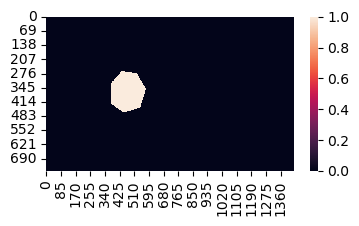

In [33]:
# mask visualization section
print(raw_data["mask"].shape)
plt.figure(figsize=(4, 2))
sns.heatmap(raw_data["mask"])

(185, 2)


<Axes: >

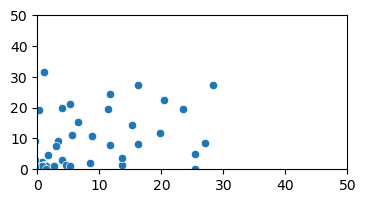

In [47]:
# mesh_d0 visualization section
print(raw_data["mesh_d0"].shape)
plt.figure(figsize=(4, 2))
plt.xlim(0, 50)
plt.ylim(0, 50)
sns.scatterplot(x = raw_data["mesh_d0"][:,0], y = raw_data["mesh_d0"][:,1], )

In [50]:
# neighbours visualization section
print(raw_data["neighbors"].shape)
print(raw_data["neighbors"])

(185, 40)
[[  0   1   9 ...  58  24  57]
 [  1   0   2 ...  49  60  61]
 [  2   1   3 ...  61  29  37]
 ...
 [182 173 181 ... 146 139 133]
 [183 174 182 ... 140 178 155]
 [184 180 181 ... 144 152 156]]


(185, 2)


<Axes: >

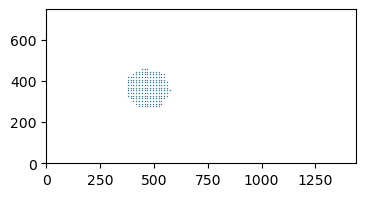

In [62]:
# point_positions visualization section
print(raw_data["point_positions"].shape)
plt.figure(figsize=(4, 2))
plt.xlim(0, 1440)
plt.ylim(0, 750)
sns.scatterplot(x = raw_data["point_positions"][:,0], y = raw_data["point_positions"][:,1], s =1)

In [82]:
# points_tracked visualization section
print(raw_data["points_tracked"]["0"].shape)

(33485, 185, 2)


In [89]:
# violations section
print(raw_data["violations"]["0"])

{'col': array([ 16,  25,  26, ..., 151, 152, 153]), 'data': array([ True,  True,  True, ...,  True,  True,  True]), 'row': array([21548, 21548, 21548, ..., 31760, 31760, 31760]), 'shape': array([33485,   185])}
